**Input:** 
- UK Biobank cancer-related fields
- ACCEL dataset (Katori et al. 2022)


**Process:**
 - Extract the subset population with ACCEL dataset available
 - See whether cancer makes any difference in ACCEL features

**Output:**


# Preparation (Execute all in this section!)

## Import libraries & set environment variables

In [1]:
import collections
import csv
from datetime import datetime
import os
import numpy as np
import pandas as pd
from pathlib import Path
import polars as pl
import re
from matplotlib import pyplot as plt

from scipy import stats
from sklearn.preprocessing import MinMaxScaler
from sklearn import linear_model
import statsmodels.api as sm

from contextlib import redirect_stdout
from io import StringIO

import warnings
# suppress DeprecationWarning messages
warnings.filterwarnings("ignore", category=DeprecationWarning)


# Draw flowcharts using Mermaid
import base64
from IPython.display import Image, display

def mm(graph):
  graphbytes = graph.encode("ascii")
  base64_bytes = base64.b64encode(graphbytes)
  base64_string = base64_bytes.decode("ascii")
  display(Image(url="https://mermaid.ink/img/" + base64_string))


dir_home = Path(os.getcwd()).parent.parent.parent
os.chdir(dir_home)
print("Current directory (check that it's your home directory):", os.getcwd())

Current directory (check that it's your home directory): J:\sugai\UKBiobank


In [2]:
DIR_SOURCE = os.path.join("data", "accel_ukbb", "split")
DIR_OUT = os.path.join("analysis", "specific", "analysis_20230510_01_ACCEL_cancer")

if not os.path.exists(DIR_OUT):
    os.makedirs(DIR_OUT)

In [4]:
mm("""
graph TD;
    classDef dark fill:#DDDDDD, stroke:#DDDDDD, font-size:12px
    UKBB[UKBB population: 502,386] --> ACCEL[ACCEL data available: 81,496];
    ACCEL -.-> C1[cancer record before accelerometry: 11,684]:::dark;
    ACCEL --> C2[cancer record after accelerometry: 6,098];
    ACCEL --> C3[no cancer record: 63,714];
""")


## Functions

In [185]:
def merge_files(list_files, dir):
    list_files = [os.path.join(dir, file) for file in list_files]

    # Initialize an empty DataFrame
    df_merged = pl.DataFrame()
    
    print(datetime.now(), "Start processing", len(list_files), "files")

    # Loop over each file in the list and add it to the merged DataFrame
    for i, file in enumerate(list_files):
        func_print(i + 1)
        # Read in the current file as a DataFrame
        df_current = pl.read_csv(file, separator="\t")

        # Get the column name for the current file's specific column
        column_name = os.path.splitext(os.path.basename(file))[0]

        # Rename the specific column to the name of the current file
        #df_current = df_current.rename(columns={df_current.columns[1]: column_name})
        df_current = df_current.rename({df_current.columns[1]: column_name})

        # If this is the first file being added, simply set df_merged to df_current
        if df_merged.shape == (0, 0):
            df_merged = df_current

        # Otherwise, merge df_current with df_merged on the "eid" column
        else:
            df_merged = df_merged.join(df_current, on="eid", how="outer")
    print(datetime.now(), "Done processing.")
    return df_merged
    

def func_print(i, suffix=""):
    if i < 10 or str(i)[1:].count('0') == len(str(i))-1:
        now = datetime.now()
        print(f"{now.strftime('%Y-%m-%d %H:%M:%S')}: {i}", suffix)


# Define a function to convert the date string into a single integer
def date_string_to_int(date_str):
    if not date_str:
        result = "NA"
    else:
        date_start = datetime.strptime("1970-10-10", '%Y-%m-%d').date()
        result = (date_str - date_start).days
    return result

        
# Define the custom date conversion function
def convert_date_format(date_str: str) -> str:
    if date_str == "NA":
        formatted_date = "NA"
    else:
        date_obj = datetime.strptime(date_str, "%Y-%m-%dT%H:%M:%S")
        formatted_date = date_obj.strftime("%Y-%m-%d")
    return formatted_date


# Convert anything to np.float32
def pl_to_float(df):
    result = df.to_numpy()
    try:
        result = result.astype(float)
    except:
        if "-" in result[0]: # Date-time format
            # Convert the date strings to datetime objects
            result = np.array([datetime.fromisoformat(date_str) for date_str in result])

            # Extract the date component and convert to integer
            result = np.array([int(date_obj.timestamp()) for date_obj in result])
    return result


# Check normality
def test_normality(pheno_list_continuous, df):
    pval_min = 1
    for pheno in pheno_list_continuous:
        print(pheno)
        try:
            np_df = pl_to_float(df[pheno])
            pval = stats.kstest(np_df, "norm")[1]
            print("P-value =", pval)
            if not np.isnan(pval):
                pval_min = min(pval, pval_min)
        except:
            print("Skip because the data is not valid ")
    if pval_min < 0.05 / len(pheno_list_continuous):
        is_normal = False
    else:
        is_normal = True
    print()
    print("Minimum p-value = ", pval_min, ", therefore normality =", is_normal)
    
    

def zscore(x, axis = None):
    xmean = x.mean(axis=axis, keepdims=True)
    xstd  = np.std(x, axis=axis, keepdims=True)
    # Replace zero values in xstd with np.nan to prevent division by zero
    xstd = np.where(xstd==0, np.nan, xstd)
    zscore = (x-xmean)/xstd
    # Replace np.nan values with 1 in zscore
    zscore = np.where(np.isnan(zscore), 1, zscore)
    return zscore


def func_linreg(df_onehot, pheno_objective, pheno_list_confounding, pheno_list_ignore):
    result_list = [["Objective_phenotype", "Explanatory_phenotype_main",
                    "Explanatory_phenotype_confounding",
                    "N", "N_zero",
                    "params_intercept", "params_X", 
                    "pval_intercept", "pval_X", 
                    "r^2", "Condition_number"]]
    
    # Make a list of explanatory variables to test one by one    
    pheno_list_explanatory = df_onehot.columns
    for pheno in ([pheno_objective] + pheno_list_confounding + pheno_list_ignore):
        try:
            pheno_list_explanatory.remove(pheno)
        except:
            pass
    
    # Test explanatory variables one by one, adding confounding factors each time
    for pheno in pheno_list_explanatory:
        pheno_list_X_Y = [pheno] + pheno_list_confounding + [pheno_objective]
        pheno_list_X = [pheno] + pheno_list_confounding
        
        # Dataset without empty fields for linear regression
        df_temp = df_onehot[pheno_list_X_Y].drop_nulls() 
        N = df_temp.shape[0]
        N0 = df_temp.filter(pl.col(pheno_objective) == 0).shape[0]
        
        
        # Stop if too few instances
        if df_temp.shape[0] < 10:
            result_list.append([pheno_objective, pheno, 
                                ",".join(pheno_list_confounding),
                                N, N0,
                                "NA_instances_fewerThan_10", "NA_instances_fewerThan_10",
                                "NA_instances_fewerThan_10", "NA_instances_fewerThan_10",
                                "NA_instances_fewerThan_10", "NA_instances_fewerThan_10"
                               ])
            continue

        X = df_temp[pheno_list_X].to_numpy().astype(np.float64)
        Y = df_temp[pheno_objective].to_numpy().astype(np.float64)

        var_pheno_explanatory = np.max(X[:, 0]) - np.min(X[:, 0])
        var_pheno_objective = np.max(Y) - np.min(Y)     
        if (var_pheno_explanatory == 0):
            result_list.append([pheno_objective, pheno, 
                                ",".join(pheno_list_confounding),
                                N, N0,
                                "NA_X_variance_is_zero", "NA_X_variance_is_zero",
                                "NA_X_variance_is_zero", "NA_X_variance_is_zero",
                                "NA_X_variance_is_zero", "NA_X_variance_is_zero"
                               ])
        elif (var_pheno_objective == 0):
            result_list.append([pheno_objective, pheno,
                                ",".join(pheno_list_confounding),
                                N, N0,
                                "NA_Y_variance_is_zero", "NA_Y_variance_is_zero",
                                "NA_Y_variance_is_zero", "NA_Y_variance_is_zero",
                                "NA_Y_variance_is_zero", "NA_Y_variance_is_zero",
                               ])        
        else:
            # Normalize X & scale Y
            X = zscore(X, axis=0)
            scaler = MinMaxScaler(feature_range=(0, 1))
            Y = scaler.fit_transform(Y.reshape(-1, 1)).flatten()



            # Add a constant to the independent variable
            X = sm.add_constant(X)

            # Perform the linear regression analysis
            model = sm.OLS(Y, X)
            results = model.fit()

            # Summary of the linear regression analysis
            # print(results.summary())
            result_list.append([pheno_objective, pheno,
                                ",".join(pheno_list_confounding),
                                N, N0,
                                results.params[0], results.params[1],
                                results.pvalues[0], results.pvalues[1],
                                results.rsquared, results.condition_number,
                               ])
    
    return result_list

## Variables

In [3]:
list_source_files = [
"ukb671006_22286_40005-0.0.txt",
"ukb671006_22287_40005-1.0.txt",
"ukb671006_22288_40005-2.0.txt",
"ukb671006_22289_40005-3.0.txt",
"ukb671006_22290_40005-4.0.txt",
"ukb671006_22291_40005-5.0.txt",
"ukb671006_22292_40005-6.0.txt",
"ukb671006_22293_40005-7.0.txt",
"ukb671006_22294_40005-8.0.txt",
"ukb671006_22295_40005-9.0.txt",
"ukb671006_22296_40005-10.0.txt",
"ukb671006_22297_40005-11.0.txt",
"ukb671006_22298_40005-12.0.txt",
"ukb671006_22299_40005-13.0.txt",
"ukb671006_22300_40005-14.0.txt",
"ukb671006_22301_40005-15.0.txt",
"ukb671006_22302_40005-16.0.txt",
"ukb671006_22303_40005-17.0.txt",
"ukb671006_22304_40005-18.0.txt",
"ukb671006_22305_40005-19.0.txt",
"ukb671006_22306_40005-20.0.txt",
"ukb671006_22307_40005-21.0.txt",
"ukb671006_24430_90010-0.0.txt",
"ukb671006_28449_day_num.txt",
"ukb671006_28450_ST_long_mean.txt",
"ukb671006_28451_ST_long_sd.txt",
"ukb671006_28452_WT_long_mean.txt",
"ukb671006_28453_WT_long_sd.txt",
"ukb671006_28454_ST_short_mean.txt",
"ukb671006_28455_ST_short_sd.txt",
"ukb671006_28456_WT_short_mean.txt",
"ukb671006_28457_WT_short_sd.txt",
"ukb671006_28458_long_window_len_mean.txt",
"ukb671006_28459_long_window_len_sd.txt",
"ukb671006_28460_long_window_num_mean.txt",
"ukb671006_28461_long_window_num_sd.txt",
"ukb671006_28462_short_window_len_mean.txt",
"ukb671006_28463_short_window_len_sd.txt",
"ukb671006_28464_short_window_num_mean.txt",
"ukb671006_28465_short_window_num_sd.txt",
"ukb671006_28466_phase_mean.txt",
"ukb671006_28467_phase_sd.txt",
"ukb671006_28468_max_period.txt",
"ukb671006_28469_amplitude.txt",
"ukb671006_28470_sleep_percentage.txt",
"ukb671006_28471_continuous_day.txt",
"ukb671006_28472_age.txt",
"ukb671006_28473_sex.txt",
"ukb671006_28475_group_eid_old.txt",
"ukb671006_28476_abnormal_group_eid_old.txt",
"ukb671006_28480_group_five.txt",]

 
cols_cancer_date = [
"ukb671006_22286_40005-0.0", 
"ukb671006_22287_40005-1.0", 
"ukb671006_22288_40005-2.0", 
"ukb671006_22289_40005-3.0", 
"ukb671006_22290_40005-4.0", 
"ukb671006_22291_40005-5.0", 
"ukb671006_22292_40005-6.0", 
"ukb671006_22293_40005-7.0", 
"ukb671006_22294_40005-8.0", 
"ukb671006_22295_40005-9.0", 
"ukb671006_22296_40005-10.0", 
"ukb671006_22297_40005-11.0", 
"ukb671006_22298_40005-12.0", 
"ukb671006_22299_40005-13.0", 
"ukb671006_22300_40005-14.0", 
"ukb671006_22301_40005-15.0", 
"ukb671006_22302_40005-16.0", 
"ukb671006_22303_40005-17.0", 
"ukb671006_22304_40005-18.0", 
"ukb671006_22305_40005-19.0", 
"ukb671006_22306_40005-20.0", 
"ukb671006_22307_40005-21.0", 
]

# Categorical variables
pheno_list_categorical = [
    "ukb671006_28475_group_eid_old",
    "ukb671006_28476_abnormal_group_eid_old",
    "ukb671006_28480_group_five",
]

# Continuous variables
pheno_list_continuous = [
    "ukb671006_28450_ST_long_mean",
    "ukb671006_28451_ST_long_sd",
    "ukb671006_28452_WT_long_mean",
    "ukb671006_28453_WT_long_sd",
    "ukb671006_28454_ST_short_mean",
    "ukb671006_28455_ST_short_sd",
    "ukb671006_28456_WT_short_mean",
    "ukb671006_28457_WT_short_sd",
    "ukb671006_28458_long_window_len_mean",
    "ukb671006_28459_long_window_len_sd",
    "ukb671006_28460_long_window_num_mean",
    "ukb671006_28461_long_window_num_sd",
    "ukb671006_28462_short_window_len_mean",
    "ukb671006_28463_short_window_len_sd",
    "ukb671006_28464_short_window_num_mean",
    "ukb671006_28465_short_window_num_sd",
    "ukb671006_28466_phase_mean",
    "ukb671006_28467_phase_sd",
    "ukb671006_28468_max_period",
    "ukb671006_28469_amplitude",
    "ukb671006_28470_sleep_percentage",
]


# Confounding factors
pheno_list_confounding = [
    'ukb671006_28472_age',
    'ukb671006_28473_sex',
]

pheno_list_ignore = ["eid", "ukb671006_24430_90010-0.0_days", "earliest_cancer_days"]

# Preprocess

## Merge the relevant fields

In [56]:
df_source = merge_files(list_source_files, DIR_SOURCE)

2023-05-10 10:51:38.928003 Start processing 51 files
2023-05-10 10:51:38: 1
2023-05-10 10:51:39: 2
2023-05-10 10:51:40: 3
2023-05-10 10:51:40: 4
2023-05-10 10:51:41: 5
2023-05-10 10:51:42: 6
2023-05-10 10:51:43: 7
2023-05-10 10:51:43: 8
2023-05-10 10:51:44: 9
2023-05-10 10:51:45: 10
2023-05-10 10:51:51: 20
2023-05-10 10:51:59: 30
2023-05-10 10:52:07: 40
2023-05-10 10:52:16: 50
2023-05-10 10:52:18.745747 Done processing.


In [58]:
df_source

shape: (502_386, 52)
┌─────────┬────────────────────────┬───────────────────────┬───────────────────────┬───┬─────────────────────┬───────────────────────┬───────────────────────┬───────────────────────┐
│ eid     ┆ ukb671006_22286_40005- ┆ ukb671006_22287_40005 ┆ ukb671006_22288_40005 ┆ … ┆ ukb671006_28473_sex ┆ ukb671006_28475_group ┆ ukb671006_28476_abnor ┆ ukb671006_28480_group │
│ ---     ┆ 0.0                    ┆ -1.0                  ┆ -2.0                  ┆   ┆ ---                 ┆ _eid_old              ┆ mal_group_e…          ┆ _five                 │
│ i64     ┆ ---                    ┆ ---                   ┆ ---                   ┆   ┆ str                 ┆ ---                   ┆ ---                   ┆ ---                   │
│         ┆ str                    ┆ str                   ┆ str                   ┆   ┆                     ┆ str                   ┆ str                   ┆ str                   │
╞═════════╪════════════════════════╪═══════════════════════╪═══════════════════════╪═══╪═════════════════════╪═══════════════════════╪═══════════════════════╪═══════════════════════╡
│ 1000010 ┆ NA                     ┆ NA                    ┆ NA                    ┆ … ┆ NA                  ┆ NA                    ┆ NA                    ┆ NA                    │
│ 1000028 ┆ 2008-05-13             ┆ 2017-02-02            ┆ NA                    ┆ … ┆ NA                  ┆ NA                    ┆ NA                    ┆ NA                    │
│ 1000034 ┆ NA                     ┆ NA                    ┆ NA                    ┆ … ┆ NA                  ┆ NA                    ┆ NA                    ┆ NA                    │
│ 1000045 ┆ NA                     ┆ NA                    ┆ NA                    ┆ … ┆ NA                  ┆ NA                    ┆ NA                    ┆ NA                    │
│ …       ┆ …                      ┆ …                     ┆ …                     ┆ … ┆ …                   ┆ …                     ┆ …                     ┆ …                     │
│ 6024804 ┆ NA                     ┆ NA                    ┆ NA                    ┆ … ┆ NA                  ┆ NA                    ┆ NA                    ┆ NA                    │
│ 6024818 ┆ NA                     ┆ NA                    ┆ NA                    ┆ … ┆ 0                   ┆ 1                     ┆ NA                    ┆ 1                     │
│ 6024820 ┆ NA                     ┆ NA                    ┆ NA                    ┆ … ┆ NA                  ┆ NA                    ┆ NA                    ┆ NA                    │
│ 6024833 ┆ NA                     ┆ NA                    ┆ NA                    ┆ … ┆ NA                  ┆ NA                    ┆ NA                    ┆ NA                    │
└─────────┴────────────────────────┴───────────────────────┴───────────────────────┴───┴─────────────────────┴───────────────────────┴───────────────────────┴───────────────────────┘

limit_output extension: Maximum message size of 10000 exceeded with 32992 characters

## Date of cancer diagnosis
- Calculate the earliest date of cancer diagnosis
- Flag whether the cancer diagnosis is before or after the accelerometry measurement

In [75]:
df = df_source.clone()

# convert the columns to Date
for i_col in cols_cancer_date:

    df = df.with_columns(
            pl.col(i_col)
            .str.strptime(pl.Date, fmt="%Y-%m-%d", strict=False)
            .alias(i_col)
        )
    
# calculate the earliest date for each row
earliest_cancer = df[cols_cancer_date].min(axis=1)

# Preserve only the earliest date
df = df.with_columns(earliest_cancer.alias("earliest_cancer")).drop(cols_cancer_date)

# Apply the custom function to the "ukb671006_24430_90010-0.0" column
df = df.with_columns(
    pl.col("ukb671006_24430_90010-0.0")
    .apply(convert_date_format, return_dtype=pl.Utf8)
    .str.strptime(pl.Date, fmt="%Y-%m-%d", strict=False)
    .alias("ukb671006_24430_90010-0.0")
)



accel_after_cancer = (df['ukb671006_24430_90010-0.0'] > df['earliest_cancer']).cast(pl.Boolean)

df = (df
                .with_columns(accel_after_cancer.alias("accel_after_cancer"))
                .with_columns(pl.col('ukb671006_24430_90010-0.0')
                              .apply(date_string_to_int)
                              .alias("ukb671006_24430_90010-0.0_days")
                              .cast(pl.Int32, strict=False)
                             )
                .with_columns(pl.col('earliest_cancer')
                              .apply(date_string_to_int)
                              .alias("earliest_cancer_days")
                              .cast(pl.Int32, strict=False)
                             )                              
               )
df

eid,ukb671006_24430_90010-0.0,ukb671006_28449_day_num,ukb671006_28450_ST_long_mean,ukb671006_28451_ST_long_sd,ukb671006_28452_WT_long_mean,ukb671006_28453_WT_long_sd,ukb671006_28454_ST_short_mean,ukb671006_28455_ST_short_sd,ukb671006_28456_WT_short_mean,ukb671006_28457_WT_short_sd,ukb671006_28458_long_window_len_mean,ukb671006_28459_long_window_len_sd,ukb671006_28460_long_window_num_mean,ukb671006_28461_long_window_num_sd,ukb671006_28462_short_window_len_mean,ukb671006_28463_short_window_len_sd,ukb671006_28464_short_window_num_mean,ukb671006_28465_short_window_num_sd,ukb671006_28466_phase_mean,ukb671006_28467_phase_sd,ukb671006_28468_max_period,ukb671006_28469_amplitude,ukb671006_28470_sleep_percentage,ukb671006_28471_continuous_day,ukb671006_28472_age,ukb671006_28473_sex,ukb671006_28475_group_eid_old,ukb671006_28476_abnormal_group_eid_old,ukb671006_28480_group_five,earliest_cancer,accel_after_cancer,ukb671006_24430_90010-0.0_days,earliest_cancer_days
i64,date,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,date,bool,i32,i32
1000010,null,"""NA""","""NA""","""NA""","""NA""","""NA""","""NA""","""NA""","""NA""","""NA""","""NA""","""NA""","""NA""","""NA""","""NA""","""NA""","""NA""","""NA""","""NA""","""NA""","""NA""","""NA""","""NA""","""NA""","""NA""","""NA""","""NA""","""NA""","""NA""",null,null,null,null
1000028,2014-10-31,"""NA""","""NA""","""NA""","""NA""","""NA""","""NA""","""NA""","""NA""","""NA""","""NA""","""NA""","""NA""","""NA""","""NA""","""NA""","""NA""","""NA""","""NA""","""NA""","""NA""","""NA""","""NA""","""NA""","""NA""","""NA""","""NA""","""NA""","""NA""",2008-05-13,true,16092,13730
1000034,null,"""NA""","""NA""","""NA""","""NA""","""NA""","""NA""","""NA""","""NA""","""NA""","""NA""","""NA""","""NA""","""NA""","""NA""","""NA""","""NA""","""NA""","""NA""","""NA""","""NA""","""NA""","""NA""","""NA""","""NA""","""NA""","""NA""","""NA""","""NA""",null,null,null,null
1000045,null,"""NA""","""NA""","""NA""","""NA""","""NA""","""NA""","""NA""","""NA""","""NA""","""NA""","""NA""","""NA""","""NA""","""NA""","""NA""","""NA""","""NA""","""NA""","""NA""","""NA""","""NA""","""NA""","""NA""","""NA""","""NA""","""NA""","""NA""","""NA""",null,null,null,null
1000052,null,"""NA""","""NA""","""NA""","""NA""","""NA""","""NA""","""NA""","""NA""","""NA""","""NA""","""NA""","""NA""","""NA""","""NA""","""NA""","""NA""","""NA""","""NA""","""NA""","""NA""","""NA""","""NA""","""NA""","""NA""","""NA""","""NA""","""NA""","""NA""",null,null,null,null
1000069,null,"""NA""","""NA""","""NA""","""NA""","""NA""","""NA""","""NA""","""NA""","""NA""","""NA""","""NA""","""NA""","""NA""","""NA""","""NA""","""NA""","""NA""","""NA""","""NA""","""NA""","""NA""","""NA""","""NA""","""NA""","""NA""","""NA""","""NA""","""NA""",null,null,null,null
1000076,2014-03-17,"""6.0""","""408.0833333333…","""83.08450350229…","""53.91666666666…","""22.49891972715…","""34.66666666666…","""55.54177606890…","""2.833333333333…","""4.624812308503…","""462.0""","""93.65183749754…","""1.0""","""0.0""","""56.25""","""49.82030208659…","""0.666666666666…","""0.745355992499…","""960.75""","""35.79658968859…","""1439.999999999…","""0.641583920993…","""0.307754629629…","""6.0""","""69""","""0""","""4b""","""NA""","""4""",null,null,15864,null
1000087,null,"""NA""","""NA""","""NA""","""NA""","""NA""","""NA""","""NA""","""NA""","""NA""","""NA""","""NA""","""NA""","""NA""","""NA""","""NA""","""NA""","""NA""","""NA""","""NA""","""NA""","""NA""","""NA""","""NA""","""NA""","""NA""","""NA""","""NA""","""NA""",null,null,null,null
1000091,2015-06-27,"""6.0""","""215.3333333333…","""98.56624957639…","""23.0""","""14.30908802125…","""73.33333333333…","""83.99338598299…","""22.91666666666…","""27.38067546443…","""286.0""","""29.75903224232…","""0.833333333333…","""0.372677996249…","""36.09375""","""38.21003580131…","""2.666666666666…","""1.699673171197…","""960.4166666666…","""58.07855073566…","""1421.999999999…","""0.477603314889…"

limit_output extension: Maximum message size of 10000 exceeded with 20675 characters

In [77]:
df_filtered = (df
               .filter(pl.col("ukb671006_28475_group_eid_old") != "NA")
               .drop(["ukb671006_24430_90010-0.0", 
                      "ukb671006_28449_day_num",
                      "earliest_cancer"])
               )
df_filtered

eid,ukb671006_28450_ST_long_mean,ukb671006_28451_ST_long_sd,ukb671006_28452_WT_long_mean,ukb671006_28453_WT_long_sd,ukb671006_28454_ST_short_mean,ukb671006_28455_ST_short_sd,ukb671006_28456_WT_short_mean,ukb671006_28457_WT_short_sd,ukb671006_28458_long_window_len_mean,ukb671006_28459_long_window_len_sd,ukb671006_28460_long_window_num_mean,ukb671006_28461_long_window_num_sd,ukb671006_28462_short_window_len_mean,ukb671006_28463_short_window_len_sd,ukb671006_28464_short_window_num_mean,ukb671006_28465_short_window_num_sd,ukb671006_28466_phase_mean,ukb671006_28467_phase_sd,ukb671006_28468_max_period,ukb671006_28469_amplitude,ukb671006_28470_sleep_percentage,ukb671006_28471_continuous_day,ukb671006_28472_age,ukb671006_28473_sex,ukb671006_28475_group_eid_old,ukb671006_28476_abnormal_group_eid_old,ukb671006_28480_group_five,accel_after_cancer,ukb671006_24430_90010-0.0_days,earliest_cancer_days
i64,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,bool,i32,i32
1000076,"""408.0833333333…","""83.08450350229…","""53.91666666666…","""22.49891972715…","""34.66666666666…","""55.54177606890…","""2.833333333333…","""4.624812308503…","""462.0""","""93.65183749754…","""1.0""","""0.0""","""56.25""","""49.82030208659…","""0.666666666666…","""0.745355992499…","""960.75""","""35.79658968859…","""1439.999999999…","""0.641583920993…","""0.307754629629…","""6.0""","""69""","""0""","""4b""","""NA""","""4""",null,15864,null
1000091,"""215.3333333333…","""98.56624957639…","""23.0""","""14.30908802125…","""73.33333333333…","""83.99338598299…","""22.91666666666…","""27.38067546443…","""286.0""","""29.75903224232…","""0.833333333333…","""0.372677996249…","""36.09375""","""38.21003580131…","""2.666666666666…","""1.699673171197…","""960.4166666666…","""58.07855073566…","""1421.999999999…","""0.477603314889…","""0.207349537037…","""6.0""","""67""","""1""","""3b""","""NA""","""3""",null,16331,null
1000162,"""512.375""","""45.02273731127…","""110.625""","""56.50594548363…","""39.125""","""38.66421957055…","""18.75""","""21.18519530238…","""623.0""","""99.46041926314…","""1.0""","""0.0""","""46.3""","""35.20596540360…","""1.25""","""1.089724735885…","""926.75""","""6.675514961409…","""1439.999999999…","""0.740724781467…","""0.392534722222…","""4.0""","""51""","""1""","""4b""","""NA""","""4""",null,16181,null
1000171,"""461.3""","""56.67503859725…","""64.6""","""33.89896753589…","""4.0""","""8.0""","""0.8""","""1.600000000000…","""525.9""","""49.81907265295…","""1.0""","""0.0""","""24.0""","""0.0""","""0.2""","""0.400000000000…","""895.3""","""10.42401074443…","""1439.999999999…","""0.670661740528…","""0.325625""","""5.0""","""59""","""0""","""4b""","""NA""","""4""",null,16057,null
1000196,"""425.75""","""47.03256850311…","""27.91666666666…","""7.683405639573…","""24.5""","""32.60112472497…","""10.66666666666…","""12.17123202017…","""453.6666666666…","""46.80782223327…","""1.0""","""0.0""","""52.75""","""43.49928160326…","""0.666666666666…","""0.471404520791…","""992.75""","""42.70221500890…","""1439.999999999…","""0.655325496636…","""0.318171296296…","""6.0""","""54""","""0""","""4b""","""NA""","""4""",null,16448,null
1000209,"""412.1""","""99.94718605343…","""43.4""","""6.952697318307…","""16.5""","""27.82804340948…","""14.0""","""26.28497669772…","""455.5""","""102.4758508137…","""1.0""","""0.0""","""76.25""","""61.75""","""0.4""","""0.489897948556…","""899.1""","""15.61857868053…","""1439.999999999…","""0.619383319809…","""0.29875""","""5.0""","""53""","""0""","""4b""","""NA""","""4""",null,16107,null
1000235,"""449.25""","""14.08234710550…","""50.75""","""22.07138041295…","""7.5""","""9.345230512584…","""7.166666666666…","""5.763872155263…","""500.0""","""26.82194375258…","""1.0""","""0.0""","""22.0""","""11.07925990308…","""0.666666666666…","""0.471404520791…","""866.6666666666…","""43.43641585377…","""1439.999999999…","""0.641835431175…","""0.320370370370…","""6.0""","""53""","""0""","""4b""","""NA""

limit_output extension: Maximum message size of 10000 exceeded with 21413 characters

In [117]:
# Make a one-hot table
df_onehot = df_filtered.clone()

# Convert categorical variables to one-hot
for pheno in pheno_list_categorical:
    onehot = df_onehot[pheno].to_dummies()
    df_onehot = pl.concat([df_onehot, onehot], how="horizontal").drop(pheno)

# Convert boolean to int
mapping = {0: 1, 1: None, 2: 0}
df_onehot = df_onehot.with_columns(
    df_onehot["accel_after_cancer"]
    .fill_null(value=2)
    .apply(lambda x: mapping[x])
    .alias("accel_after_cancer")
)    
    
# Value count
print(df_onehot.groupby("accel_after_cancer", maintain_order=True).agg(pl.count()))

df_onehot

shape: (3, 2)
┌────────────────────┬───────┐
│ accel_after_cancer ┆ count │
│ ---                ┆ ---   │
│ i64                ┆ u32   │
╞════════════════════╪═══════╡
│ 0                  ┆ 63692 │
│ null               ┆ 11682 │
│ 1                  ┆ 6098  │
└────────────────────┴───────┘


shape: (81_472, 50)
┌─────────┬───────────────────────┬───────────────────────┬───────────────────────┬───┬───────────────────────┬───────────────────────┬───────────────────────┬──────────────────────┐
│ eid     ┆ ukb671006_28450_ST_lo ┆ ukb671006_28451_ST_lo ┆ ukb671006_28452_WT_lo ┆ … ┆ ukb671006_28480_group ┆ ukb671006_28480_group ┆ ukb671006_28480_group ┆ ukb671006_28480_grou │
│ ---     ┆ ng_mean               ┆ ng_sd                 ┆ ng_mean               ┆   ┆ _five_2               ┆ _five_3               ┆ _five_4               ┆ p_five_5             │
│ i64     ┆ ---                   ┆ ---                   ┆ ---                   ┆   ┆ ---                   ┆ ---                   ┆ ---                   ┆ ---                  │
│         ┆ str                   ┆ str                   ┆ str                   ┆   ┆ u8                    ┆ u8                    ┆ u8                    ┆ u8                   │
╞═════════╪═══════════════════════╪═══════════════════════╪═══════════════════════╪═══╪═══════════════════════╪═══════════════════════╪═══════════════════════╪══════════════════════╡
│ 1000076 ┆ 408.08333333333326    ┆ 83.0845035022911      ┆ 53.91666666666666     ┆ … ┆ 0                     ┆ 0                     ┆ 1                     ┆ 0                    │
│ 1000091 ┆ 215.3333333333333     ┆ 98.56624957639177     ┆ 23.0                  ┆ … ┆ 0                     ┆ 1                     ┆ 0                     ┆ 0                    │
│ 1000162 ┆ 512.375               ┆ 45.02273731127418     ┆ 110.625               ┆ … ┆ 0                     ┆ 0                     ┆ 1                     ┆ 0                    │
│ 1000171 ┆ 461.3                 ┆ 56.67503859725197     ┆ 64.6                  ┆ … ┆ 0                     ┆ 0                     ┆ 1                     ┆ 0                    │
│ …       ┆ …                     ┆ …                     ┆ …                     ┆ … ┆ …                     ┆ …                     ┆ …                     ┆ …                    │
│ 6024605 ┆ 317.0                 ┆ 64.84532879604102     ┆ 66.83333333333333     ┆ … ┆ 0                     ┆ 0                     ┆ 1                     ┆ 0                    │
│ 6024698 ┆ 424.0                 ┆ 42.469989404284064    ┆ 45.4                  ┆ … ┆ 0                     ┆ 0                     ┆ 0                     ┆ 1                    │
│ 6024737 ┆ 387.0                 ┆ 34.37295448459442     ┆ 80.91666666666667     ┆ … ┆ 0                     ┆ 0                     ┆ 1                     ┆ 0                    │
│ 6024818 ┆ 552.5                 ┆ 163.41511557992425    ┆ 298.8333333333333     ┆ … ┆ 0                     ┆ 0                     ┆ 0                     ┆ 0                    │
└─────────┴───────────────────────┴───────────────────────┴───────────────────────┴───┴───────────────────────┴───────────────────────┴───────────────────────┴──────────────────────┘

limit_output extension: Maximum message size of 10000 exceeded with 26669 characters

In [118]:
FILE_OUT = os.path.join(DIR_OUT, "annotated.csv")
df.write_csv(FILE_OUT)

FILE_OUT = os.path.join(DIR_OUT, "filtered.csv")
df_filtered.write_csv(FILE_OUT)

FILE_OUT = os.path.join(DIR_OUT, "one_hot.csv")
df_onehot.write_csv(FILE_OUT)

# Linear regression and more

## Read the file
- Reload `df_onehot` from file to re-infer each column type

In [4]:
file = os.path.join(DIR_OUT, "one_hot.csv")
df_onehot = (pl.read_csv(file, infer_schema_length=None)
            .with_columns(pl.col("eid").cast(pl.Int32)))
df_onehot

eid,ukb671006_28450_ST_long_mean,ukb671006_28451_ST_long_sd,ukb671006_28452_WT_long_mean,ukb671006_28453_WT_long_sd,ukb671006_28454_ST_short_mean,ukb671006_28455_ST_short_sd,ukb671006_28456_WT_short_mean,ukb671006_28457_WT_short_sd,ukb671006_28458_long_window_len_mean,ukb671006_28459_long_window_len_sd,ukb671006_28460_long_window_num_mean,ukb671006_28461_long_window_num_sd,ukb671006_28462_short_window_len_mean,ukb671006_28463_short_window_len_sd,ukb671006_28464_short_window_num_mean,ukb671006_28465_short_window_num_sd,ukb671006_28466_phase_mean,ukb671006_28467_phase_sd,ukb671006_28468_max_period,ukb671006_28469_amplitude,ukb671006_28470_sleep_percentage,ukb671006_28471_continuous_day,ukb671006_28472_age,ukb671006_28473_sex,accel_after_cancer,ukb671006_24430_90010-0.0_days,earliest_cancer_days,ukb671006_28475_group_eid_old_1,ukb671006_28475_group_eid_old_2a,ukb671006_28475_group_eid_old_2b,ukb671006_28475_group_eid_old_3a,ukb671006_28475_group_eid_old_3b,ukb671006_28475_group_eid_old_4a,ukb671006_28475_group_eid_old_4b,ukb671006_28475_group_eid_old_5,ukb671006_28476_abnormal_group_eid_old_3b-1,ukb671006_28476_abnormal_group_eid_old_3b-2,ukb671006_28476_abnormal_group_eid_old_4b-1,ukb671006_28476_abnormal_group_eid_old_4b-2,ukb671006_28476_abnormal_group_eid_old_4b-3,ukb671006_28476_abnormal_group_eid_old_4b-4,ukb671006_28476_abnormal_group_eid_old_4b-5,ukb671006_28476_abnormal_group_eid_old_4b-6,ukb671006_28476_abnormal_group_eid_old_NA,ukb671006_28480_group_five_1,ukb671006_28480_group_five_2,ukb671006_28480_group_five_3,ukb671006_28480_group_five_4,ukb671006_28480_group_five_5
i32,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64
1000076,408.083333,83.084504,53.916667,22.49892,34.666667,55.541776,2.833333,4.624812,462.0,93.651837,1.0,0.0,56.25,49.820302,0.666667,0.745356,960.75,35.79659,1440.0,0.641584,0.307755,6.0,69,0,0,15864,null,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0
1000091,215.333333,98.56625,23.0,14.309088,73.333333,83.993386,22.916667,27.380675,286.0,29.759032,0.833333,0.372678,36.09375,38.210036,2.666667,1.699673,960.416667,58.078551,1422.0,0.477603,0.20735,6.0,67,1,0,16331,null,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0
1000162,512.375,45.022737,110.625,56.505945,39.125,38.66422,18.75,21.185195,623.0,99.460419,1.0,0.0,46.3,35.205965,1.25,1.089725,926.75,6.675515,1440.0,0.740725,0.392535,4.0,51,1,0,16181,null,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0
1000171,461.3,56.675039,64.6,33.898968,4.0,8.0,0.8,1.6,525.9,49.819073,1.0,0.0,24.0,0.0,0.2,0.4,895.3,10.424011,1440.0,0.670662,0.325625,5.0,59,0,0,16057,null,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0
1000196,425.75,47.032569,27.916667,7.683406,24.5,32.601125,10.666667,12.171232,453.666667,46.807822,1.0,0.0,52.75,43.499282,0.666667,0.471405,992.75,42.702215,1440.0,0.655325,0.318171,6.0,54,0,0,16448,null,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0
1000209,412.1,99.947186,43.4,6.952697,16.5,27.828043,14.0,26.284977,455.5,102.475851,1.0,0.0,76.25,61.75,0.4,0.489898,899.1,15.618579,1440.0,0.619383,0.29875,5.0,53,0,0,16107,null,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0
1000235,449.25,14.082347,50.75,22.07138,7.5,9.345231,7.166667,5.763872,500.0,26.821944,1.0,0.0,22.0,11.07926,0.666667,0.471405,866.666667,43.436416,1440.0,0.641835,0.32037,6.0,53,0,0,16142,null,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0
1000254,239.916667,125.897252,68.5,41.241161,80.5,97.910674,21.833333,19.766695,370.1,87.373566,0.833333,0.372678,76.75,77.558043,1.333333,0.745356,962.25,13.091823,1440.0,0.49903,0.224016,6.0,58,1,0,15584,null,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0
1000337,399.166667,56.688966,71.0,19.459359,28.0,57.202127,3.0,6.708204,470.166667,73.326704,1.0,0.0,93.0,80.5,0.333333,0.471405,848.833333,26.497903,1440.0,0.599609,0.297569,6.0,56,1,1,16107,16613,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0


limit_output extension: Maximum message size of 10000 exceeded with 19309 characters

# Linear regression
Multiple regression (single variable + confounding factors)

Including these confounding factors:

In [86]:
pheno_list_confounding

['ukb671006_28472_age', 'ukb671006_28473_sex']

Excluding these variables from linear regression:

In [7]:
pheno_list_ignore

['eid', 'ukb671006_24430_90010-0.0_days', 'earliest_cancer_days']

## Try on a single variable

In [151]:
# Test one
result_list = func_linreg(df_onehot, "accel_after_cancer", 
                          pheno_list_confounding, pheno_list_ignore)

print("Extract statistically significant variables")

pval_threshold = 0.05 / (len(result_list) - 1)
print("Bonferroni-corrected P-value threshold:", pval_threshold)

[l for l in result_list[1:] if l[6] < pval_threshold]

Extract statistically significant variables
Bonferroni-corrected P-value threshold: 0.0011363636363636365


[['accel_after_cancer',
  'ukb671006_28452_WT_long_mean',
  ['ukb671006_28472_age', 'ukb671006_28473_sex'],
  0.08737641495916307,
  0.004817429727778119,
  0.0,
  8.558164371062797e-06,
  0.019128334478504816,
  1.2366587860999687],
 ['accel_after_cancer',
  'ukb671006_28458_long_window_len_mean',
  ['ukb671006_28472_age', 'ukb671006_28473_sex'],
  0.08737641495916307,
  0.004656726562831029,
  0.0,
  1.1027567160545331e-05,
  0.019121527040244835,
  1.0594035693924386],
 ['accel_after_cancer',
  'ukb671006_28470_sleep_percentage',
  ['ukb671006_28472_age', 'ukb671006_28473_sex'],
  0.08737641495916307,
  0.003722341658315207,
  0.0,
  0.00046294210528435566,
  0.019022214833405937,
  1.1033391177001357]]

## Multiple variables
Only for the categorical variables consisting of 0 and 1

In [6]:
df_onehot_for_batch = df_onehot.drop(["ukb671006_28471_continuous_day",
                                     "accel_after_cancer",
                                     "ukb671006_24430_90010-0.0_days",
                                     "earliest_cancer_days"])


DIR_TABULAR = os.path.join("data", "accel_ukbb", "split")

files = [f for f in os.listdir(DIR_TABULAR) if f.endswith(".txt")]
files = sorted(files)
print(len(files, "files are found"))

In [190]:
#flag_skip = True
result_list = []

for i, file_name in enumerate(files):
    func_print(i, suffix=file_name)
#     if "_2365-" in file_name:
#         flag_skip = False
#     if flag_skip:
#         continue
    
    pheno_id = re.sub(".*ukb671006", "", file_name)
    pheno_id = pheno_id[7:]
    pheno_id = re.sub(".txt", "", pheno_id)
    array_num = re.sub(".*-", "", pheno_id)
    if array_num != "0.0": # Treat only the first member of array
        continue
    
    # Read each file
    file_path = os.path.join(DIR_TABULAR, file_name)
    df = pl.read_csv(file_path, separator="\t", infer_schema_length=0)
    pheno_objective = df.columns[-1]
    df = (df
          .drop_nulls()
          .with_columns(pl.col("eid").cast(pl.Int32, strict=False))
          .with_columns(pl.col(pheno_objective).cast(pl.Float64, strict=False))
          .drop_nulls()
         )
    # Skip if too few
    if df.shape[0] < 10:
        continue
    
    # Skip variables with more than two-way subdivisions
    max_value = df[pheno_objective].max()
    if max_value > 1:
        continue
    # Check if one and zero are included
    zero_included = (df[pheno_objective] == 0).any()
    if not zero_included:
        continue
    one_included = (df[pheno_objective] == 1).any()
    if not one_included:
        continue
                
    # Preprocess
    # Omit NA
    try:
        df = df.filter(pl.col(pheno_objective) != "NA")
    except:
        pass
    # Omit anything else than zero and one
    df = df.filter((df[pheno_objective] == 0) | (df[pheno_objective] == 1))
    
    # Join to ACCEL data
    df = df_onehot_for_batch.join(df, on="eid", how="inner").drop("eid")

    # Stat test
    result_list_single = func_linreg(df, pheno_objective, 
                              pheno_list_confounding, [])
    if len(result_list) == 0:
        result_list.extend(result_list_single)
    else: # Omit header row
        result_list.extend(result_list_single[1:])

#     summary_table = (df
#      .groupby(pheno_objective, maintain_order=True)
#      .agg(pl.count())
#      .sort(by=pheno_objective)
#     )

#     print(summary_table.head())

2023-05-12 14:07:29: 0 ukb671006_00001_3-0.0.txt
2023-05-12 14:07:30: 1 ukb671006_00002_3-1.0.txt
2023-05-12 14:07:30: 2 ukb671006_00003_3-2.0.txt
2023-05-12 14:07:30: 3 ukb671006_00004_3-3.0.txt
2023-05-12 14:07:30: 4 ukb671006_00005_4-0.0.txt
2023-05-12 14:07:30: 5 ukb671006_00006_4-1.0.txt
2023-05-12 14:07:30: 6 ukb671006_00007_4-2.0.txt
2023-05-12 14:07:30: 7 ukb671006_00008_4-3.0.txt
2023-05-12 14:07:30: 8 ukb671006_00009_5-0.0.txt
2023-05-12 14:07:31: 9 ukb671006_00010_5-1.0.txt
2023-05-12 14:07:31: 10 ukb671006_00011_5-2.0.txt
2023-05-12 14:07:32: 20 ukb671006_00021_21-3.0.txt
2023-05-12 14:07:37: 30 ukb671006_00031_35-3.0.txt
2023-05-12 14:07:39: 40 ukb671006_00041_38-1.0.txt
2023-05-12 14:07:41: 50 ukb671006_00051_40-3.0.txt
2023-05-12 14:07:42: 60 ukb671006_00061_43-1.0.txt
2023-05-12 14:07:44: 70 ukb671006_00071_45-3.0.txt
2023-05-12 14:07:45: 80 ukb671006_00081_48-1.0.txt
2023-05-12 14:07:46: 90 ukb671006_00091_50-3.0.txt
2023-05-12 14:07:48: 100 ukb671006_00101_54-0.0.txt


In [191]:
result_list_numpy = np.array(result_list)

header = result_list_numpy[0]
data = result_list_numpy[1:]

# Create a dictionary with each key-value pair representing a column and its data
data_dict = {header[i]: data[:, i] for i in range(data.shape[1])}

# Convert the dictionary to a Polars DataFrame
df = pl.DataFrame(data_dict)

FILE_OUT = os.path.join(DIR_OUT, "result_zero_one_categorical.csv")
df.write_csv(FILE_OUT)

df

Objective_phenotype,Explanatory_phenotype_main,Explanatory_phenotype_confounding,N,N_zero,params_intercept,params_X,pval_intercept,pval_X,r^2,Condition_number
str,str,str,str,str,str,str,str,str,str,str
"""31-0.0""","""ukb671006_2845…","""ukb671006_2847…","""81472""","""46348""","""0.431117439120…","""-2.01661604082…","""0.0""","""0.225760554217…","""1.0""","""1.161635817659…"
"""31-0.0""","""ukb671006_2845…","""ukb671006_2847…","""81472""","""46348""","""0.431117439120…","""-4.72712147203…","""0.0""","""0.003931566948…","""1.0""","""1.101512932280…"
"""31-0.0""","""ukb671006_2845…","""ukb671006_2847…","""81472""","""46348""","""0.431117439120…","""-6.78168458889…","""0.0""","""5.143802189847…","""1.0""","""1.240559381510…"
"""31-0.0""","""ukb671006_2845…","""ukb671006_2847…","""81472""","""46348""","""0.431117439120…","""6.076953176781…","""0.0""","""0.000222514185…","""1.0""","""1.142821296745…"
"""31-0.0""","""ukb671006_2845…","""ukb671006_2847…","""81472""","""46348""","""0.431117439120…","""9.085614205428…","""0.0""","""4.940681647912…","""1.0""","""1.196571839312…"
"""31-0.0""","""ukb671006_2845…","""ukb671006_2847…","""81472""","""46348""","""0.431117439120…","""-7.58941520739…","""0.0""","""0.963328760638…","""1.0""","""1.147350801612…"
"""31-0.0""","""ukb671006_2845…","""ukb671006_2847…","""81472""","""46348""","""0.431117439120…","""-5.46437894932…","""0.0""","""0.001016321118…","""1.0""","""1.195479000373…"
"""31-0.0""","""ukb671006_2845…","""ukb671006_2847…","""81472""","""46348""","""0.431117439120…","""-3.03576608295…","""0.0""","""0.854954667013…","""1.0""","""1.158820799874…"
"""31-0.0""","""ukb671006_2845…","""ukb671006_2847…","""81472""","""46348""","""0.431117439120…","""1.396452398161…","""0.0""","""1.720041303208…","""1.0""","""1.075798254728…"


In [192]:
pval_threshold = 0.05 / df.shape[0]
print("Bonferroni-corrected threshold of P-value =", pval_threshold)
df_significant = (df
 .filter(~pl.col("pval_X").str.contains("NA"))
 .with_columns(pl.col("pval_X").cast(pl.Float64))
 .filter(pl.col("pval_X") < pval_threshold)
)
FILE_OUT = os.path.join(DIR_OUT, "result_zero_one_categorical_significant.csv")
df_significant.write_csv(FILE_OUT)

Bonferroni-corrected threshold of P-value = 3.0202355783751136e-06


# Plot

In [62]:
for i, file_name in enumerate(files):
    # Read each file
    file_path = os.path.join(DIR_TABULAR, file_name)
    func_print(i, suffix=file_path)
    df = pl.read_csv(file_path, separator="\t", infer_schema_length=0)
    pheno_objective = df.columns[-1]
    df = (df
          .drop_nulls()
          .with_columns(pl.col("eid").cast(pl.Int32, strict=False))
          .with_columns(pl.col(pheno_objective).cast(pl.Float64, strict=False))
          .drop_nulls()
         )
    # Preprocess
    try:
        df = df.filter(pl.col(pheno_objective) != "NA")
    except:
        pass
#    df = df.with_columns(pl.col(pheno_objective).cast(pl.Float64))
    # Join to main dataset
    df = df_onehot_for_batch.join(df, on="eid", how="inner").drop("eid")
    
    break
    
    # print(df.groupby(pheno_objective, maintain_order=True).agg(pl.count()))

2023-05-11 15:56:54: 0 data\accel_ukbb\split\ukb671006_00001_3-0.0.txt


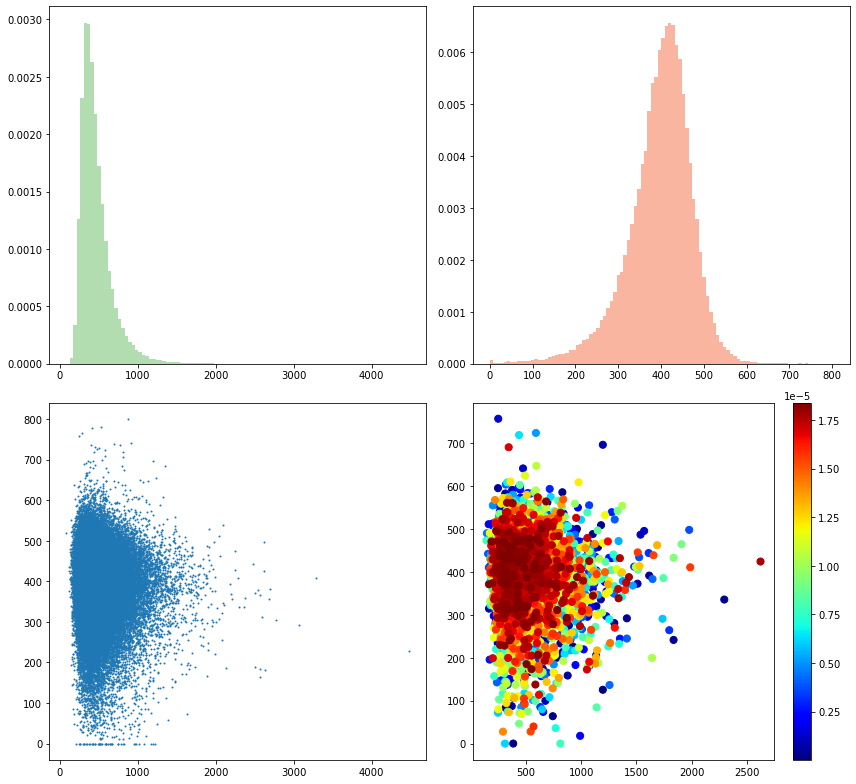

In [20]:
pheno_explanatory = "ukb671006_28450_ST_long_mean"
x = df[pheno_objective]
y = df[pheno_explanatory]

fig, axes = plt.subplots(2, 2, tight_layout=True, figsize=[12, 11])
# Plot the distribution of the pheno column for each dataframe
sub_plot = axes[0, 0]
#sub_plot.set_xlim(list_range[0], list_range[1]) 
#sub_plot.hist(np_after, alpha=0.5, label="-cancer", density=True, bins=100, color='#66bd63')
sub_plot.hist(x,
              alpha=0.5, label=pheno_objective, density=True, bins=100, color='#66bd63')

sub_plot = axes[0, 1]
pheno_explanatory = "ukb671006_28450_ST_long_mean"
sub_plot.hist(y,
              alpha=0.5, label=pheno_explanatory, density=True, bins=100, color='#f46d43')

sub_plot = axes[1, 0]
sub_plot.scatter(x, y, s=1)

sub_plot = axes[1, 1]
xy = np.vstack([x,y])[:, ::10]
z = stats.gaussian_kde(xy)(xy)
idx = z.argsort() 
x2, y2, z2 = x[idx], y[idx], z[idx]
im = sub_plot.scatter(x2, y2, c=z2, s=50, cmap="jet")
fig.colorbar(im)

# sub_plot.legend(loc="upper right", fontsize=12)
# if with_title == True:
#     sub_plot.set_title(suffix + "\n" + \
#                        str(median_after) + "(-) " + sign + " " + str(median_before) + "(+)",
#                       fontsize=24)
# sub_plot.set_xlabel("Value", fontsize=16)
# sub_plot.set_ylabel("Frequency", fontsize=16)
plt.show()